In [2]:
# augmentations = 2
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from collections import Counter

class DeceptionDataset(Dataset):
    def __init__(self, dataset_path, label_file, augmentations=2):
        """
        Args:
            dataset_path (str): Path to the dataset directory.
            label_file (str): Path to the label file.
            augmentations (int): Number of augmentations per sample (default is 2).
        """
        self.dataset_path = dataset_path

        # Collect all HOF feature files (original and augmentations)
        self.files = [f for f in os.listdir(dataset_path) if f.endswith("_hof.npy")]

        # Load labels
        label_df = pd.read_excel(label_file, usecols=["VideoID", "Veracity"])
        self.labels_dict = label_df.set_index("VideoID")["Veracity"].to_dict()

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_name = self.files[idx]
        video_id = file_name.replace("_hof.npy", "")
        file_path = os.path.join(self.dataset_path, file_name)

        # Load HOF features
        features = np.load(file_path)
        features_tensor = torch.tensor(features, dtype=torch.float32)

        # Get label (removing augmentation suffix if present)
        base_video_id = video_id.split("_aug")[0]  # Remove "_aug1" or "_aug2" suffix
        label = self.labels_dict.get(base_video_id, 0)  # Default to 0 if missing
        label_tensor = torch.tensor(label, dtype=torch.long)

        return features_tensor, label_tensor

def stratified_split(dataset, batch_size=64, val_split=0.1, test_split=0.1):
    """
    Performs a stratified train-validation-test split and returns corresponding DataLoaders.
    """
    labels = [dataset[i][1].item() for i in range(len(dataset))]
    indices = np.arange(len(dataset))

    # First, split train+val and test
    train_val_idx, test_idx, train_val_labels, test_labels = train_test_split(
        indices, labels, test_size=test_split, stratify=labels, random_state=42
    )

    # Then split train and validation
    train_idx, val_idx, train_labels, val_labels = train_test_split(
        train_val_idx, train_val_labels, test_size=val_split/(1-test_split), stratify=train_val_labels, random_state=42
    )

    # Create dataset subsets
    train_dataset = torch.utils.data.Subset(dataset, train_idx)
    val_dataset = torch.utils.data.Subset(dataset, val_idx)
    test_dataset = torch.utils.data.Subset(dataset, test_idx)

    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print(f"Train Class Distribution: {Counter(train_labels)}")
    print(f"Validation Class Distribution: {Counter(val_labels)}")
    print(f"Test Class Distribution: {Counter(test_labels)}")

    return train_loader, val_loader, test_loader


In [3]:
# Augment = 2
dataset_path = "../precomputed_hof_augmented_100"  # Update with actual path
label_file = "../pre_data.xlsx"  # Update with actual label file

# Load labels
label_df = pd.read_excel(label_file, usecols=["VideoID", "Veracity"])
label_counts = label_df["Veracity"].value_counts()
num_classes = label_df["Veracity"].nunique()

print(f"Total Classes: {num_classes}")
print("Class Distribution:\n", label_counts)
# Load dataset and check class distribution
train_loader, val_loader, test_loader = stratified_split(DeceptionDataset(dataset_path, label_file, augmentations=4), batch_size=64, val_split=0.05, test_split=0.05)

print(f"Train samples: {len(train_loader.dataset)}, Validation: {len(val_loader.dataset)}, Test: {len(test_loader.dataset)}")

Total Classes: 2
Class Distribution:
 Veracity
1    160
0    160
Name: count, dtype: int64
Train Class Distribution: Counter({1: 432, 0: 431})
Validation Class Distribution: Counter({0: 25, 1: 24})
Test Class Distribution: Counter({0: 24, 1: 24})
Train samples: 863, Validation: 49, Test: 48


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# ✅ Define optimizer (AdamW works better for Transformers)
def get_optimizer(model, learning_rate=5e-5, weight_decay=1e-3):
    return optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# ✅ Learning rate scheduler
def get_scheduler(optimizer, patience=5, factor=0.5):
    return optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=patience, verbose=True)

# ✅ Evaluation function
def evaluate_model(model, data_loader, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []

    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)  # Ensure inputs have correct shape
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            preds = outputs.argmax(1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    f1 = f1_score(all_labels, all_preds, average='macro')
    return total_loss / len(data_loader), accuracy, f1

# ✅ Training function
def train_model(model, train_loader, val_loader, test_loader, epochs=250, learning_rate=5e-5, clip_value=1.0):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = get_optimizer(model, learning_rate)
    # scheduler = get_scheduler(optimizer, patience=8, factor=0.5)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)  # Ensure Transformer gets (batch, seq_len, feature_dim)
            loss = criterion(outputs, labels)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)  # Gradient clipping
            optimizer.step()

            train_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        val_loss, val_acc, val_f1 = evaluate_model(model, val_loader, device)

        # scheduler.step(val_loss)

        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")

    print("Training complete!")

    test_loss, test_acc, test_f1 = evaluate_model(model, test_loader, device)
    print(f"\n🔍 Test Results: Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}, F1 Score: {test_f1:.4f}")

    plot_training_curves(train_losses, val_losses, train_accs, val_accs)

    return test_loss, test_acc, test_f1

# ✅ Function to plot training curves
def plot_training_curves(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss", marker="o")
    plt.plot(epochs, val_losses, label="Val Loss", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training & Validation Loss")

    # Accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label="Train Accuracy", marker="o")
    plt.plot(epochs, val_accs, label="Val Accuracy", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Training & Validation Accuracy")

    plt.show()

In [5]:
class CNN_Model(nn.Module):
    def __init__(self, num_features=1056, num_classes=2):
        super(CNN_Model, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1056, out_channels=512, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=512, out_channels=256, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(1536, num_classes)  # Adjust size after pooling
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Change to (batch, feature_dim, sequence_length)
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(x)
        x = self.fc(x)
        return self.softmax(x)

Epoch 1/80: Train Loss: 9.7103, Train Acc: 0.4844, Val Loss: 0.6929, Val Acc: 0.5102, Val F1: 0.3378
Epoch 2/80: Train Loss: 9.6975, Train Acc: 0.5377, Val Loss: 0.6929, Val Acc: 0.5102, Val F1: 0.3378
Epoch 3/80: Train Loss: 9.6966, Train Acc: 0.5168, Val Loss: 0.6930, Val Acc: 0.5102, Val F1: 0.3718
Epoch 4/80: Train Loss: 9.6818, Train Acc: 0.5701, Val Loss: 0.6930, Val Acc: 0.5306, Val F1: 0.3825
Epoch 5/80: Train Loss: 9.6745, Train Acc: 0.5944, Val Loss: 0.6929, Val Acc: 0.5306, Val F1: 0.4368
Epoch 6/80: Train Loss: 9.6634, Train Acc: 0.6107, Val Loss: 0.6928, Val Acc: 0.5102, Val F1: 0.3718
Epoch 7/80: Train Loss: 9.6746, Train Acc: 0.5921, Val Loss: 0.6928, Val Acc: 0.5306, Val F1: 0.4746
Epoch 8/80: Train Loss: 9.6583, Train Acc: 0.6396, Val Loss: 0.6927, Val Acc: 0.5102, Val F1: 0.4432
Epoch 9/80: Train Loss: 9.6453, Train Acc: 0.6686, Val Loss: 0.6929, Val Acc: 0.4898, Val F1: 0.3288
Epoch 10/80: Train Loss: 9.6398, Train Acc: 0.6651, Val Loss: 0.6927, Val Acc: 0.5714, Val 

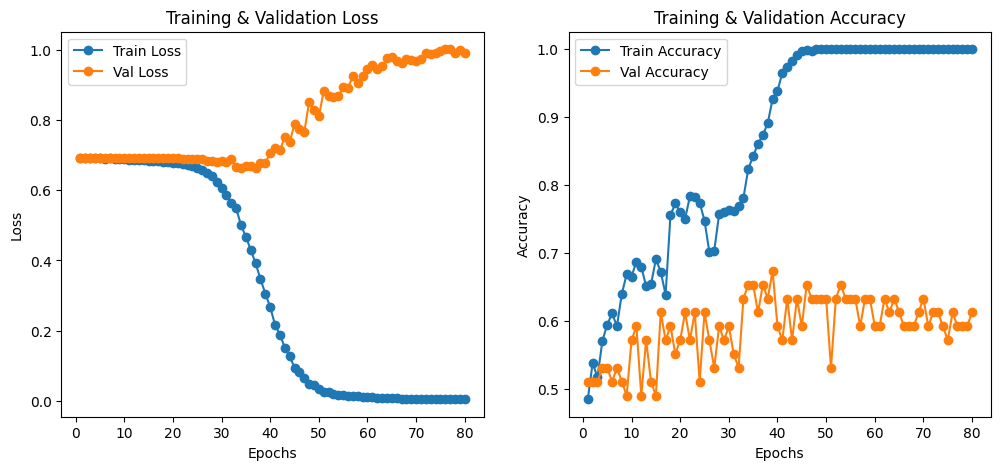

In [11]:
# augmented training
model = CNN_Model()
test_loss, test_acc, test_f1 = train_model(model, train_loader, val_loader, test_loader, epochs=80, learning_rate=5e-5, clip_value=1.0)


              precision    recall  f1-score   support

   Deceptive       0.75      0.75      0.75        24
    Truthful       0.75      0.75      0.75        24

    accuracy                           0.75        48
   macro avg       0.75      0.75      0.75        48
weighted avg       0.75      0.75      0.75        48



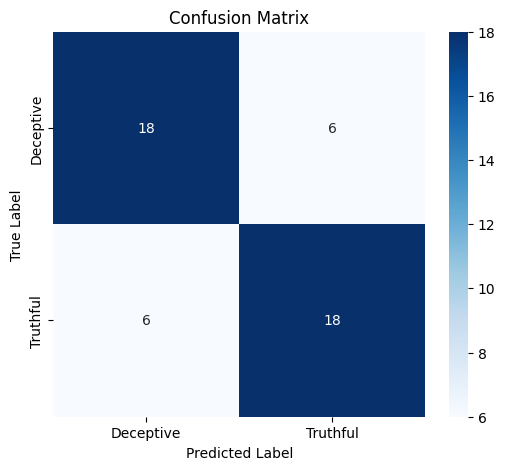

In [12]:
# augment = 4
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
def plot_confusion_matrix(true_labels, pred_labels, class_names):
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

def evaluate_and_plot(model, data_loader, class_names, device):
    """Evaluates the model and plots confusion matrix."""
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 🔹 Print classification report
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # 🔹 Plot confusion matrix
    plot_confusion_matrix(all_labels, all_preds, class_names)

# After training, call this function
class_names = ["Deceptive", "Truthful"]  # Modify based on your dataset
evaluate_and_plot(model, test_loader, class_names, device)


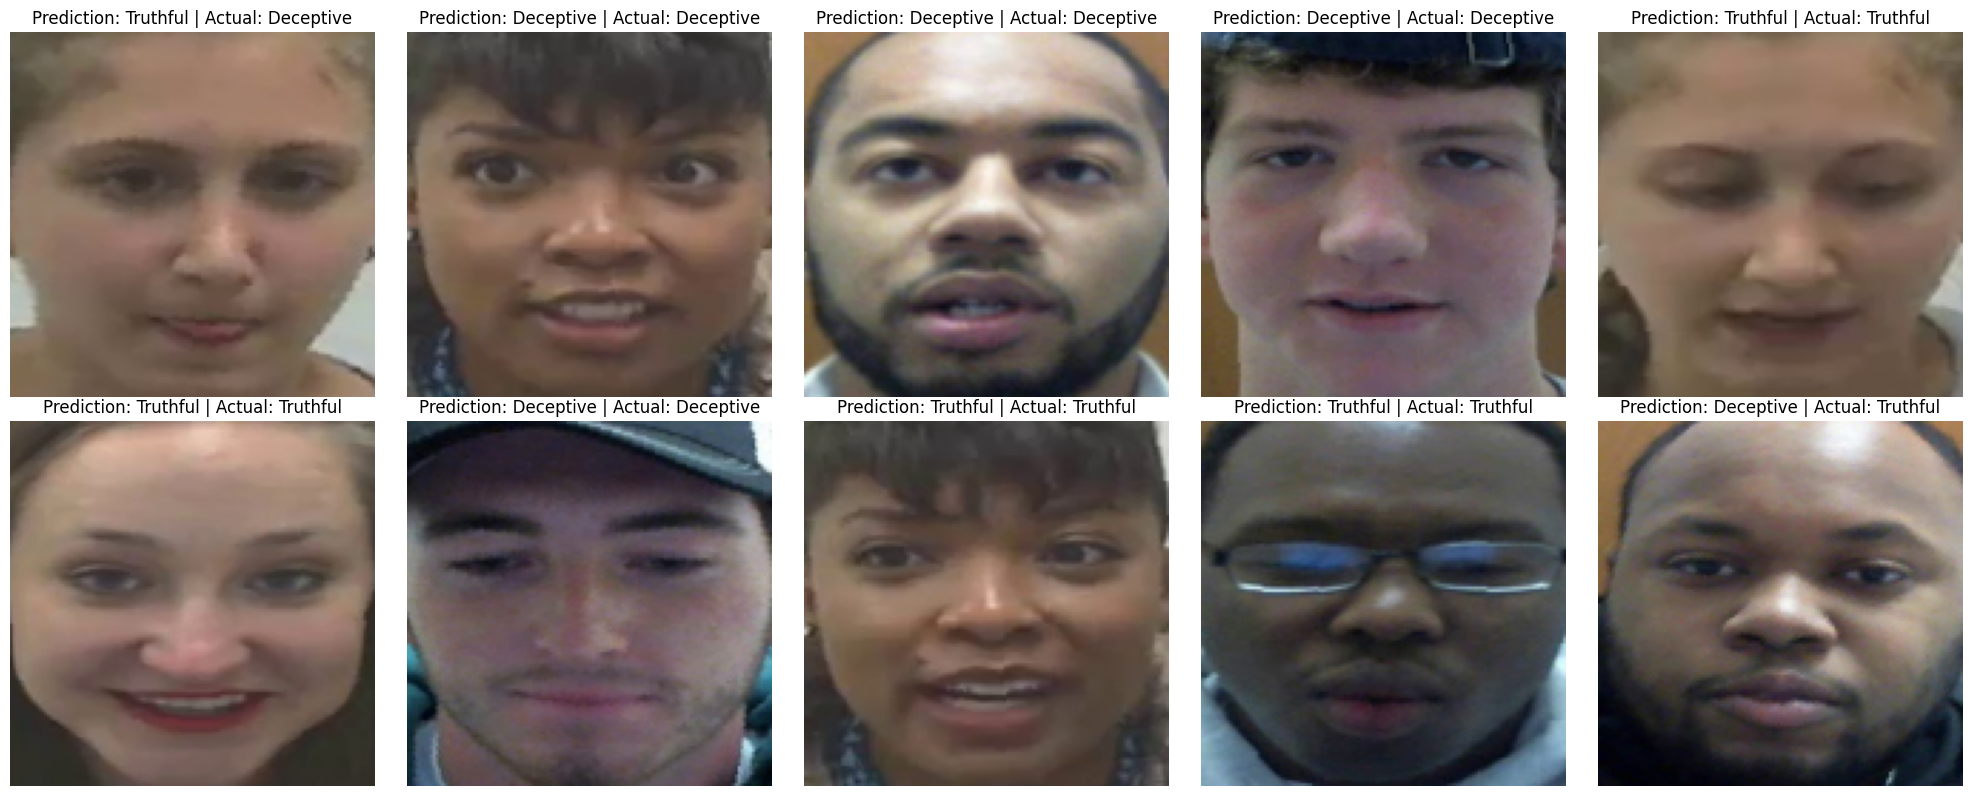

In [25]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

LABELS = {0: "Deceptive", 1: "Truthful"}

def visualize_predictions(model, dataset, num_videos=10):
    model.to(device)
    model.eval()
    
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))  # 2 rows, 5 columns
    axes = axes.ravel()  # Flatten for easier indexing
    
    for i in range(num_videos):
        # Handle Subset datasets
        if isinstance(dataset, torch.utils.data.Subset):
            original_dataset = dataset.dataset
            index_in_original = dataset.indices[i]
        else:
            original_dataset = dataset
            index_in_original = i
        
        # Get data sample
        hof_features, label = original_dataset[index_in_original]
        
        # Move tensors to the correct device
        hof_features = hof_features.unsqueeze(0).to(device)

        # Run model inference
        with torch.no_grad():
            output = model(hof_features)
            predicted_label = torch.argmax(output, dim=1).item()

        # Extract base video ID (removing _aug1, _aug2, etc.)
        video_id = original_dataset.files[index_in_original].replace("_hof.npy", "")
        video_id = video_id.split("_aug")[0]  # Remove "_aug1", "_aug2" suffix
        
        # Load the first frame of the video
        frame_path = os.path.join("../dataset_200_3_points", video_id, "frame_0000.png")
        frame = cv2.imread(frame_path)
        
        if frame is None:
            print(f"Frame not found: {frame_path}")
            continue

        # Convert to RGB for matplotlib
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Plot the image
        axes[i].imshow(frame)
        true_label_text = LABELS.get(label.item(), "Unknown")
        pred_label_text = LABELS.get(predicted_label, "Unknown")
        axes[i].set_title(f"Prediction: {pred_label_text} | Actual: {true_label_text}", fontsize=12)
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()


# Example usage
visualize_predictions(model, test_loader.dataset, num_videos=10)


In [1]:
torch.save(model.state_dict(), "deception_model.pth")
print("Model saved successfully!")

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


NameError: name 'torch' is not defined